In [2]:
from matplotlib import pyplot as plt
from slab import datamanagement
from slab import dsfit
from slab import dataanalysis
from slab.datamanagement import SlabFile
from numpy import *
from numpy import linalg
%matplotlib inline
%config InlineBackend.figure_format='retina'
from tabulate import tabulate

data_dir = r'S:\_Data\160216 -M007 Trident Hybrid Coupler setup\data'
exp_dir = r'S:\_Data\160216 -M007 Trident Hybrid Coupler setup\experiment'
nbfig_dir = r'C:\Users\slab\Google Drive\grad school\schuster lab\Analysis\IPython Notebooks\Figures'

sys.path.append(exp_dir)
sys.path.append(r'C:\Users\slab\Google Drive\grad school\schuster lab')
from data_cache import dataCacheProxy
from Analysis.Modules import common, fit, anal, static_surface, trap_analysis

## For M016

### Differential Mode

C:\Users\slab\Google Drive\grad school\schuster lab\Analysis\Modules\static_surface.py:332: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X*1E6, Y*1E6, np.log10(E), cmap=cmap)


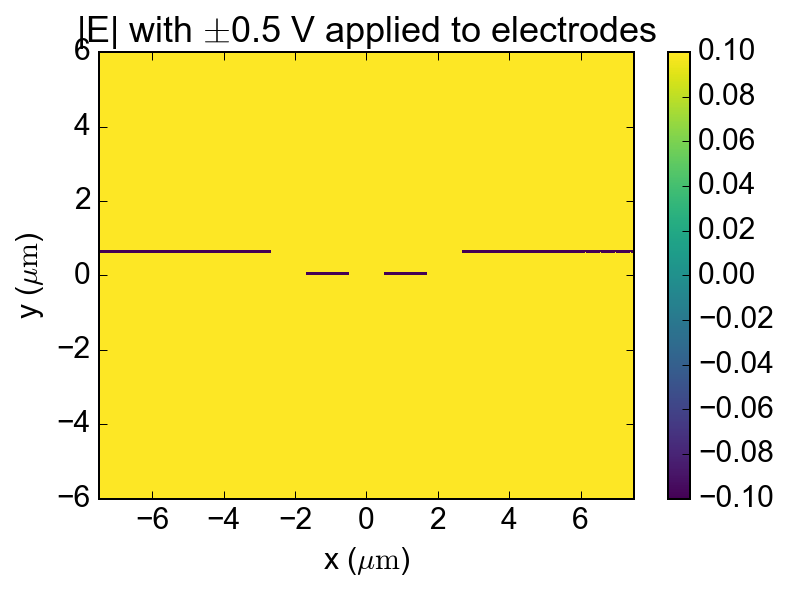

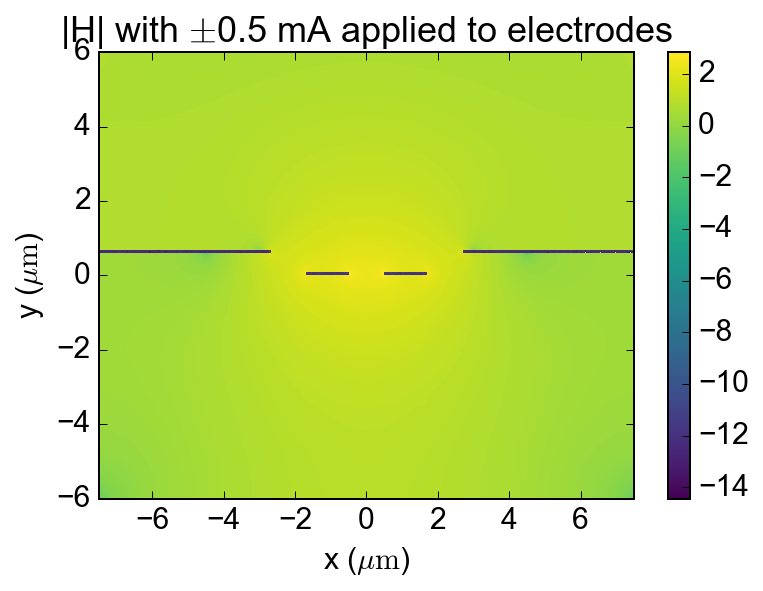

In [3]:
basepath = r'S:\Gerwin\Electron on helium\Maxwell\M016 Capacitance Inductance\0.1 pct solution'
magE_fn = r'magEDifferentialMode.fld'
magH_fn = r'magHDifferentialMode.fld'

x, y, magE = static_surface.load_maxwell_data(os.path.join(basepath, magE_fn), do_log=True, 
                                              figsize=(6.,4.), plot_axes='xy', cmap=plt.cm.viridis, ylim=None)
plt.title('|E| with $\pm$0.5 V applied to electrodes')

x, y, magH = static_surface.load_maxwell_data(os.path.join(basepath, magH_fn), do_log=True, 
                                              figsize=(6.,4.), plot_axes='xy', cmap=plt.cm.viridis, ylim=None)
plt.title('|H| with $\pm$0.5 mA applied to electrodes')

Define the regions for integrations with correct epsilons

In [4]:
etch_T = 0.6E-6
box_W = 15E-6
box_H = 12E-6

si_substrate_x = (-box_W/2., box_W/2.)
si_substrate_y = (-box_H/2., 0)

si_wall_1x = (-box_W/2., -2.7E-6)
si_wall_1y = (0, etch_T)

si_wall_2x = (2.7E-6, box_W/2.)
si_wall_2y = (0, etch_T)

eps_si = 10.00
eps_vac = 1.00
eps0 = 8.85E-12
mu0 = 4*pi*1E-7

dx = box_W/500.
dy = box_H/500.

V0 = 1.0
I0 = 1E-3

In [5]:
xSiSubstrate, ySiSubstrate, magESiSubstrate = static_surface.select_domain(x, y, magE, xdomain=si_substrate_x, 
                                                                           ydomain=si_substrate_y)
xSiWall1, ySiWall1, magESiWall1 = static_surface.select_domain(x, y, magE, xdomain=si_wall_1x, 
                                                                           ydomain=si_wall_1y)
xSiWall2, ySiWall2, magESiWall2 = static_surface.select_domain(x, y, magE, xdomain=si_wall_2x, 
                                                                           ydomain=si_wall_2y)
xChan, yChan, magEChan = static_surface.select_domain(x, y, magE, xdomain=(-2.7E-6, 2.7E-6), ydomain=(0, etch_T))
xTop, yTop, magETop = static_surface.select_domain(x, y, magE, xdomain=(-box_W/2., box_W/2.), 
                                                   ydomain=(etch_T, box_H/2.))

Esquared = ( eps_si*np.sum(magESiSubstrate**2) + eps_si*np.sum(magESiWall1**2) + eps_si*np.sum(magESiWall2**2) + \
           eps_vac*np.sum(magEChan**2) + eps_vac*np.sum(magETop**2) )*dx*dy

C = eps0*Esquared/V0**2

print "Calculation gives C = %.1f pF/m"%(C*1E12)

Calculation gives C = 91.1 pF/m


Now do the same thing for the magnetic field!

In [6]:
xSiSubstrate, ySiSubstrate, magHSiSubstrate = static_surface.select_domain(x, y, magH, xdomain=si_substrate_x, 
                                                                           ydomain=si_substrate_y)
xSiWall1, ySiWall1, magHSiWall1 = static_surface.select_domain(x, y, magH, xdomain=si_wall_1x, 
                                                                           ydomain=si_wall_1y)
xSiWall2, ySiWall2, magHSiWall2 = static_surface.select_domain(x, y, magH, xdomain=si_wall_2x, 
                                                                           ydomain=si_wall_2y)
xChan, yChan, magHChan = static_surface.select_domain(x, y, magH, xdomain=(-2.7E-6, 2.7E-6), ydomain=(0, etch_T))
xTop, yTop, magHTop = static_surface.select_domain(x, y, magH, xdomain=(-box_W/2., box_W/2.), 
                                                   ydomain=(etch_T, box_H/2.))

Hsquared = ( np.sum(magHSiSubstrate**2) + np.sum(magHSiWall1**2) + np.sum(magHSiWall2**2) + \
             np.sum(magHChan**2) + np.sum(magHTop**2) )*dx*dy

L = mu0*Hsquared/I0**2

print "Calculation gives L = %.1f nH/m"%(L*1E9)

Calculation gives L = 183.3 nH/m


In [7]:
# Length should be half the entire resonator length i.e. length = lambda/4
# The length that's specified in the code is lambda/4, such that length = lambda/4= 17631/2 microns
length = 6000e-6/2.
print "Frequency = %.2f GHz"%(1/(2*pi*1E9) * 1/sqrt(L*C) * 1/length)
print "Impedance = %.2f Ohms"%(sqrt(L/C))

Frequency = 12.98 GHz
Impedance = 44.85 Ohms


### Common Mode

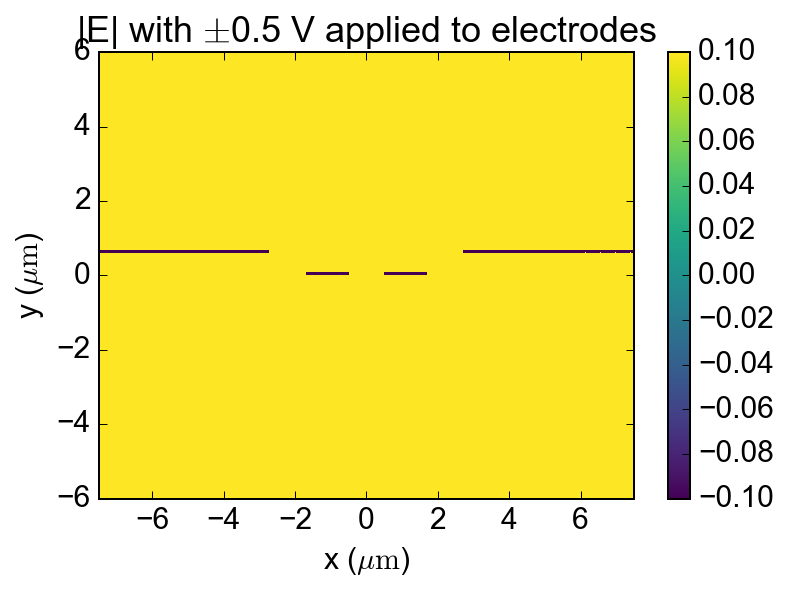

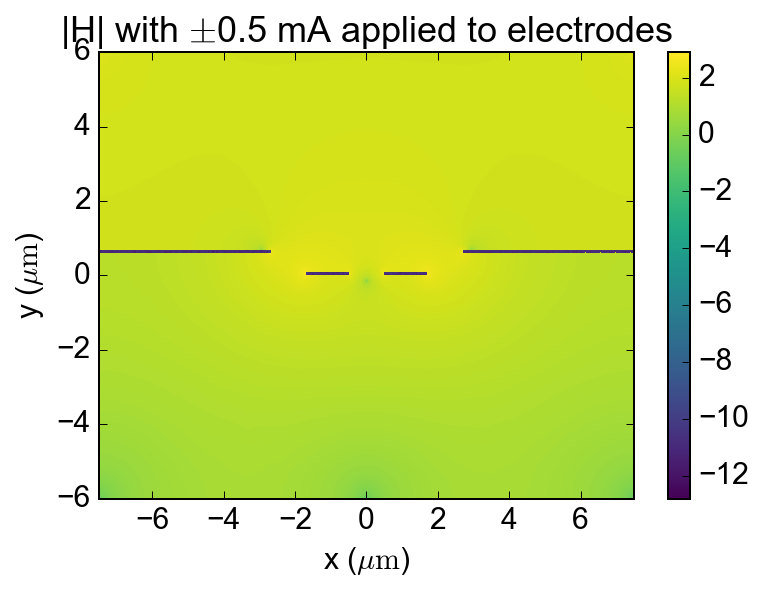

In [8]:
basepath = r'S:\Gerwin\Electron on helium\Maxwell\M016 Capacitance Inductance\0.1 pct solution'
magE_fn = r'magECommonMode.fld'
magH_fn = r'magHCommonMode.fld'

x, y, magE = static_surface.load_maxwell_data(os.path.join(basepath, magE_fn), do_log=True, 
                                              figsize=(6.,4.), plot_axes='xy', cmap=plt.cm.viridis, ylim=None)
plt.title('|E| with $\pm$0.5 V applied to electrodes')

x, y, magH = static_surface.load_maxwell_data(os.path.join(basepath, magH_fn), do_log=True, 
                                              figsize=(6.,4.), plot_axes='xy', cmap=plt.cm.viridis, ylim=None)
plt.title('|H| with $\pm$0.5 mA applied to electrodes')

In [9]:
etch_T = 0.6E-6
box_W = 15E-6
box_H = 12E-6

si_substrate_x = (-box_W/2., box_W/2.)
si_substrate_y = (-box_H/2., 0)

si_wall_1x = (-box_W/2., -2.7E-6)
si_wall_1y = (0, etch_T)

si_wall_2x = (2.7E-6, box_W/2.)
si_wall_2y = (0, etch_T)

eps_si = 10.00
eps_vac = 1.00
eps0 = 8.85E-12
mu0 = 4*pi*1E-7

dx = box_W/500.
dy = box_H/500.

V0 = 1.0
I0 = 1E-3

In [10]:
xSiSubstrate, ySiSubstrate, magESiSubstrate = static_surface.select_domain(x, y, magE, xdomain=si_substrate_x, 
                                                                           ydomain=si_substrate_y)
xSiWall1, ySiWall1, magESiWall1 = static_surface.select_domain(x, y, magE, xdomain=si_wall_1x, 
                                                                           ydomain=si_wall_1y)
xSiWall2, ySiWall2, magESiWall2 = static_surface.select_domain(x, y, magE, xdomain=si_wall_2x, 
                                                                           ydomain=si_wall_2y)
xChan, yChan, magEChan = static_surface.select_domain(x, y, magE, xdomain=(-2.7E-6, 2.7E-6), ydomain=(0, etch_T))
xTop, yTop, magETop = static_surface.select_domain(x, y, magE, xdomain=(-box_W/2., box_W/2.), 
                                                   ydomain=(etch_T, box_H/2.))

Esquared = ( eps_si*np.sum(magESiSubstrate**2) + eps_si*np.sum(magESiWall1**2) + eps_si*np.sum(magESiWall2**2) + \
           eps_vac*np.sum(magEChan**2) + eps_vac*np.sum(magETop**2) )*dx*dy

C = eps0*Esquared/V0**2

print "Calculation gives C = %.1f pF/m"%(C*1E12)

Calculation gives C = 37.1 pF/m


In [11]:
xSiSubstrate, ySiSubstrate, magHSiSubstrate = static_surface.select_domain(x, y, magH, xdomain=si_substrate_x, 
                                                                           ydomain=si_substrate_y)
xSiWall1, ySiWall1, magHSiWall1 = static_surface.select_domain(x, y, magH, xdomain=si_wall_1x, 
                                                                           ydomain=si_wall_1y)
xSiWall2, ySiWall2, magHSiWall2 = static_surface.select_domain(x, y, magH, xdomain=si_wall_2x, 
                                                                           ydomain=si_wall_2y)
xChan, yChan, magHChan = static_surface.select_domain(x, y, magH, xdomain=(-2.7E-6, 2.7E-6), ydomain=(0, etch_T))
xTop, yTop, magHTop = static_surface.select_domain(x, y, magH, xdomain=(-box_W/2., box_W/2.), 
                                                   ydomain=(etch_T, box_H/2.))

Hsquared = ( np.sum(magHSiSubstrate**2) + np.sum(magHSiWall1**2) + np.sum(magHSiWall2**2) + \
             np.sum(magHChan**2) + np.sum(magHTop**2) )*dx*dy

L = mu0*Hsquared/I0**2

print "Calculation gives L = %.1f nH/m"%(L*1E9)

Calculation gives L = 695.3 nH/m


In [12]:
# Length should be half the entire resonator length i.e. length = lambda/4
# The length that's specified in the code is lambda/4, such that length = lambda/4= 17631/2 microns
length = 6000e-6/2.
print "Frequency = %.2f GHz"%(1/(2*pi*1E9) * 1/sqrt(L*C) * 1/length)
print "Impedance = %.2f Ohms"%(sqrt(L/C))

Frequency = 10.45 GHz
Impedance = 136.94 Ohms


## For M007 

### Differential Mode

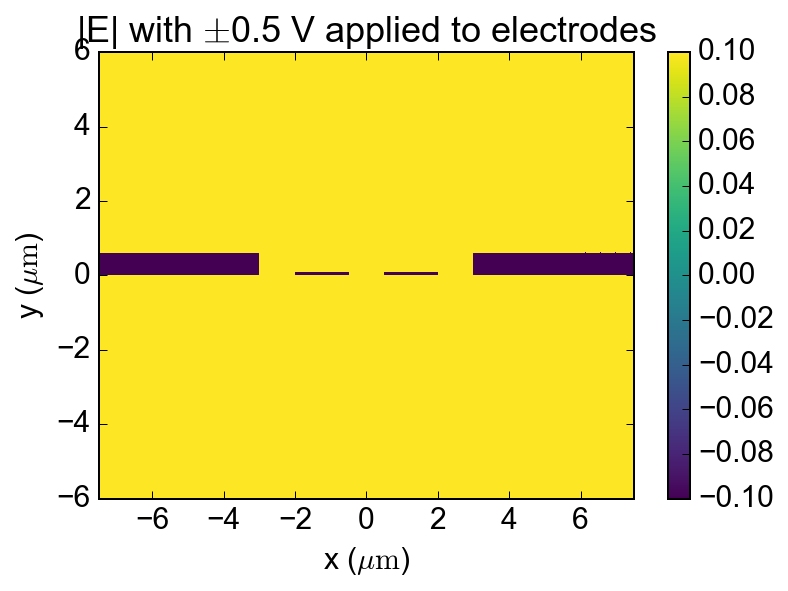

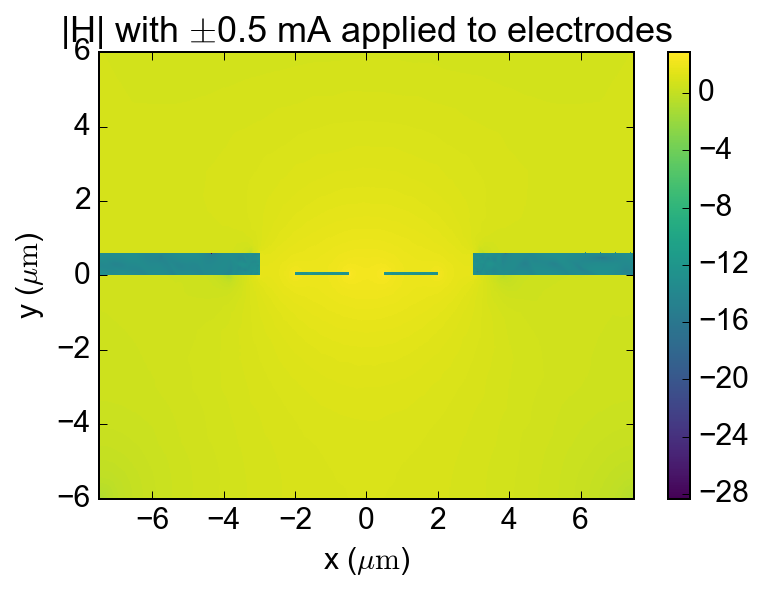

In [70]:
basepath = r'S:\Gerwin\Electron on helium\Maxwell\M007 Capacitance Inductance'
magE_fn = r'magEDifferentialMode.fld'
magH_fn = r'magHDifferentialMode.fld'

x, y, magE = static_surface.load_maxwell_data(os.path.join(basepath, magE_fn), do_log=True, 
                                              figsize=(6.,4.), plot_axes='xy', cmap=plt.cm.viridis, ylim=None)
plt.title('|E| with $\pm$0.5 V applied to electrodes')

x, y, magH = static_surface.load_maxwell_data(os.path.join(basepath, magH_fn), do_log=True, 
                                              figsize=(6.,4.), plot_axes='xy', cmap=plt.cm.viridis, ylim=None)
plt.title('|H| with $\pm$0.5 mA applied to electrodes')

In [71]:
etch_T = 0.6E-6
box_W = 15E-6
box_H = 12E-6

substrate_x = (-box_W/2., box_W/2.)
substrate_y = (-box_H/2., 0)

Nb_wall_1x = (-box_W/2., -3E-6)
Nb_wall_1y = (0, etch_T)

Nb_wall_2x = (3E-6, box_W/2.)
Nb_wall_2y = (0, etch_T)

eps_sapph = 10.9
eps_vac = 1.00
eps0 = 8.85E-12
mu0 = 4*pi*1E-7

dx = box_W/500.
dy = box_H/500.

V0 = 1
I0 = 1E-3

In [72]:
xSubstrate, ySubstrate, magESubstrate = static_surface.select_domain(x, y, magE, xdomain=substrate_x, 
                                                                     ydomain=substrate_y)
xNbWall1, yNbWall1, magENbWall1 = static_surface.select_domain(x, y, magE, xdomain=Nb_wall_1x, 
                                                                           ydomain=Nb_wall_1y)
xNbWall2, yNbWall2, magENbWall2 = static_surface.select_domain(x, y, magE, xdomain=Nb_wall_2x, 
                                                                           ydomain=Nb_wall_2y)
xChan, yChan, magEChan = static_surface.select_domain(x, y, magE, xdomain=(-3.0E-6, 3.0E-6), ydomain=(0, etch_T))
xTop, yTop, magETop = static_surface.select_domain(x, y, magE, xdomain=(-box_W/2., box_W/2.), 
                                                   ydomain=(etch_T, box_H/2.))

Esquared = ( eps_sapph*np.sum(magESubstrate**2) + 0.0*np.sum(magENbWall1**2) + 0.0*np.sum(magENbWall2**2) + \
           eps_vac*np.sum(magEChan**2) + eps_vac*np.sum(magETop**2) )*dx*dy

C = eps0*Esquared/V0**2

print "Calculation gives C = %.1f pF/m"%(C*1E12)

Calculation gives C = 108.6 pF/m


In [73]:
xcrop, ycrop, magHSubstrate = static_surface.select_domain(x, y, magH, xdomain=substrate_x, ydomain=substrate_y)
xcrop, ycrop, magHNbWall1 = static_surface.select_domain(x, y, magH, xdomain=Nb_wall_1x, ydomain=Nb_wall_1y)
xcrop, ycrop, magHNbWall2 = static_surface.select_domain(x, y, magH, xdomain=Nb_wall_2x, ydomain=Nb_wall_2y)
xcrop, ycrop, magHChan = static_surface.select_domain(x, y, magH, xdomain=(-3.0E-6, 3.0E-6), ydomain=(0, etch_T))
xcrop, ycrop, magHTop = static_surface.select_domain(x, y, magH, xdomain=(-box_W/2., box_W/2.), 
                                                     ydomain=(etch_T, box_H/2.))

Hsquared = ( np.sum(magHSubstrate**2) + np.sum(magHNbWall1**2) + np.sum(magHSiWall2**2) + \
             np.sum(magHChan**2) + np.sum(magHTop**2) )*dx*dy

L = mu0*Hsquared/I0**2

print "Calculation gives L = %.1f nH/m"%(L*1E9)

Calculation gives L = 179.1 nH/m


In [74]:
# Length should be half the entire resonator length i.e. length = lambda/4
# The length that's specified in the code is lambda/4, such that length = lambda/4= 17631/2 microns
length = 17631E-6/2.
print "Frequency = %.2f GHz"%(1/(2*pi*1E9) * 1/sqrt(L*C) * 1/length)
print "Impedance = %.2f Ohms"%(sqrt(L/C))

Frequency = 4.09 GHz
Impedance = 40.62 Ohms


### Common mode

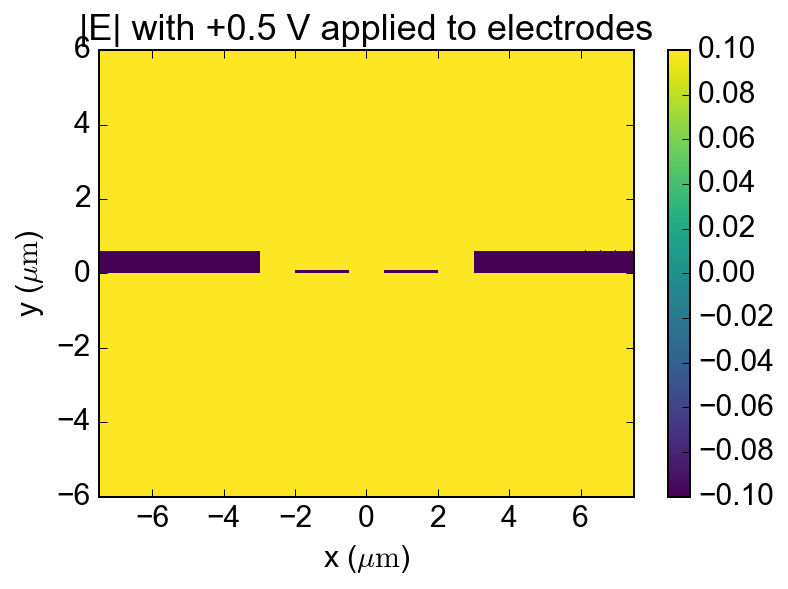

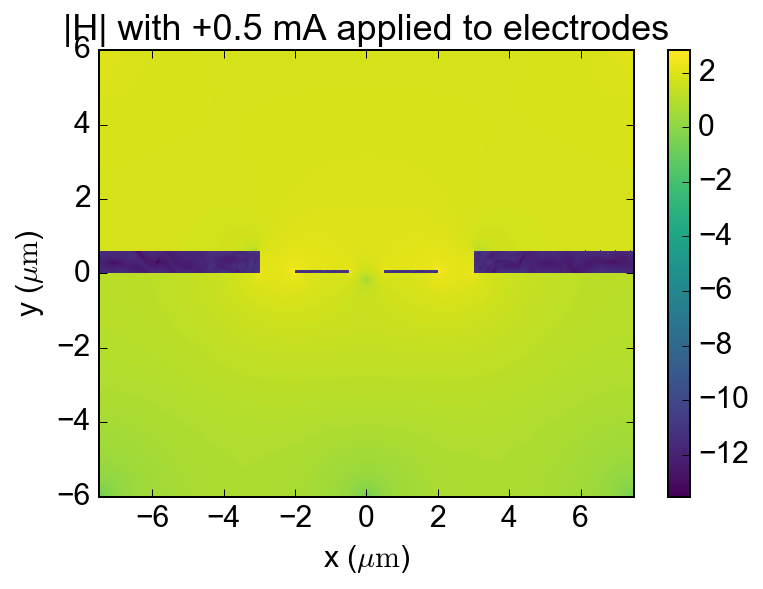

In [37]:
basepath = r'S:\Gerwin\Electron on helium\Maxwell\M007 Capacitance Inductance'
magE_fn = r'magECommonMode.fld'
magH_fn = r'magHCommonMode.fld'

x, y, magE = static_surface.load_maxwell_data(os.path.join(basepath, magE_fn), do_log=True, 
                                              figsize=(6.,4.), plot_axes='xy', cmap=plt.cm.viridis, ylim=None)
plt.title('|E| with +0.5 V applied to electrodes')

x, y, magH = static_surface.load_maxwell_data(os.path.join(basepath, magH_fn), do_log=True, 
                                              figsize=(6.,4.), plot_axes='xy', cmap=plt.cm.viridis, ylim=None)
plt.title('|H| with +0.5 mA applied to electrodes')

In [47]:
etch_T = 0.6E-6
box_W = 15E-6
box_H = 12E-6

substrate_x = (-box_W/2., box_W/2.)
substrate_y = (-box_H/2., 0)

Nb_wall_1x = (-box_W/2., -3E-6)
Nb_wall_1y = (0, etch_T)

Nb_wall_2x = (3E-6, box_W/2.)
Nb_wall_2y = (0, etch_T)

eps_sapph = 10.9
eps_vac = 1.00
eps0 = 8.85E-12
mu0 = 4*pi*1E-7

dx = box_W/500.
dy = box_H/500.

V0 = 1
I0 = 1E-3

In [48]:
xSubstrate, ySubstrate, magESubstrate = static_surface.select_domain(x, y, magE, xdomain=substrate_x, 
                                                                     ydomain=substrate_y)
xNbWall1, yNbWall1, magENbWall1 = static_surface.select_domain(x, y, magE, xdomain=Nb_wall_1x, 
                                                                           ydomain=Nb_wall_1y)
xNbWall2, yNbWall2, magENbWall2 = static_surface.select_domain(x, y, magE, xdomain=Nb_wall_2x, 
                                                                           ydomain=Nb_wall_2y)
xChan, yChan, magEChan = static_surface.select_domain(x, y, magE, xdomain=(-3.0E-6, 3.0E-6), ydomain=(0, etch_T))
xTop, yTop, magETop = static_surface.select_domain(x, y, magE, xdomain=(-box_W/2., box_W/2.), 
                                                   ydomain=(etch_T, box_H/2.))

Esquared = ( eps_sapph*np.sum(magESubstrate**2) + 0.0*np.sum(magENbWall1**2) + 0.0*np.sum(magENbWall2**2) + \
           eps_vac*np.sum(magEChan**2) + eps_vac*np.sum(magETop**2) )*dx*dy

C = eps0*Esquared/V0**2

print "Calculation gives C = %.1f pF/m"%(C*1E12)

Calculation gives C = 49.3 pF/m


In [49]:
xcrop, ycrop, magHSubstrate = static_surface.select_domain(x, y, magH, xdomain=substrate_x, ydomain=substrate_y)
xcrop, ycrop, magHNbWall1 = static_surface.select_domain(x, y, magH, xdomain=Nb_wall_1x, ydomain=Nb_wall_1y)
xcrop, ycrop, magHNbWall2 = static_surface.select_domain(x, y, magH, xdomain=Nb_wall_2x, ydomain=Nb_wall_2y)
xcrop, ycrop, magHChan = static_surface.select_domain(x, y, magH, xdomain=(-3.0E-6, 3.0E-6), ydomain=(0, etch_T))
xcrop, ycrop, magHTop = static_surface.select_domain(x, y, magH, xdomain=(-box_W/2., box_W/2.), 
                                                     ydomain=(etch_T, box_H/2.))

Hsquared = ( np.sum(magHSubstrate**2) + np.sum(magHNbWall1**2) + np.sum(magHSiWall2**2) + \
             np.sum(magHChan**2) + np.sum(magHTop**2) )*dx*dy

L = mu0*Hsquared/I0**2

print "Calculation gives L = %.1f nH/m"%(L*1E9)

Calculation gives L = 650.7 nH/m


In [50]:
# Length should be half the entire resonator length i.e. length = lambda/4
# The length that's specified in the code is lambda/4, such that length = lambda/4= 17631/2 microns
length = 17631E-6/2.
print "Frequency = %.2f GHz"%(1/(2*pi*1E9) * 1/sqrt(L*C) * 1/length)
print "Impedance = %.2f Ohms"%(sqrt(L/C))

Frequency = 6.38 GHz
Impedance = 114.92 Ohms


### Pozar calculations

In [59]:
epseff = ( eps_sapph*np.sum(magESubstrate**2) + eps_vac*np.sum(magEChan**2) + eps_vac*np.sum(magETop**2) )*dx*dy \
           / ((np.sum(magESubstrate**2) + np.sum(magEChan**2) + np.sum(magETop**2) )*dx*dy)

print "Effective dielectric constant eps_eff = %.2f"%epseff

Effective dielectric constant eps_eff = 5.24


In [63]:
# Here the length should be the entire length of the resonator. 
speed = 3.0E8/sqrt(epseff)
L = 17631E-6
f0 = 8.11E9

print "Length for f0 = %.2f GHz: l = %d um"%(f0/1E9, speed/(2*f0)*1E6)
print "Resonance frequency for L = %.0f um: f0 = %.2f GHz"%(L*1E6, speed/(2*L)*1E-9)

Length for f0 = 8.11 GHz: l = 8076 um
Resonance frequency for L = 17631 um: f0 = 3.72 GHz


### Dave's thesis calculations

In [1]:
# The differential mode for M016: Cl = 205 pF/m, Ll = 323 nH/m
# Here the length should be the entire length of the resonator, i.e. 2 x the quarter wave length.
# The length is roughly 4.4 cm (44E3 um)
length=22100*2E-6
f1 = 1/(2*length) * 1/sqrt(205E-12*323E-9) * 1E-9
f3 = 3*f1

print "For M016, the two frequencies are calculated as\n* lambda/2 : f1 = %.2f GHz\n* 3 lambda/2 : f3 = %.2f GHz"%(f1, f3)

For M016, the two frequencies are calculated as
* lambda/2 : f1 = 1.39 GHz
* 3 lambda/2 : f3 = 4.17 GHz


In [3]:
# The differential mode for M007 has Cl = 192 pF/m and Ll = 296 nH/m
# The length was roughly 1.7 cm
length=17631*1E-6
f1 = 1/(2*length) * 1/sqrt(192E-12*296E-9) * 1E-9
f3 = 3*f1

print "For M007, the two frequencies are calculated as\n* lambda/2 : f1 = %.2f GHz\n* 3 lambda/2 : f3 = %.2f GHz"%(f1, f3)

For M007, the two frequencies are calculated as
* lambda/2 : f1 = 3.76 GHz
* 3 lambda/2 : f3 = 11.29 GHz


In [29]:
# For the new resonator has Cl = 205 pF/m, Ll = 323 nH/m
# The length was roughly is 6 mm
length=6000E-6
f1 = 1/(2*length) * 1/sqrt(192E-12*296E-9) * 1E-9
f3 = 3*f1

print "For M016 with the new lengths, the two frequencies are calculated as\n* lambda/2 : f1 = %.2f GHz\n* 3 lambda/2 : f3 = %.2f GHz"%(f1, f3)
print "The total inductance is %.2f nH"%(2/pi**2 * 296E-9*length *1E9)
print "The total capacitance is %.2f pF"%(0.5*192E-12*length *1E12)
print "The length for the coupler should be %.2f um"%(length/1250.*1E6)

For M016 with the new lengths, the two frequencies are calculated as
* lambda/2 : f1 = 11.05 GHz
* 3 lambda/2 : f3 = 33.16 GHz
The total inductance is 0.36 nH
The total capacitance is 0.58 pF
The length for the coupler should be 4.80 um


In [22]:
1.78E-9/(4*pi*1E-7)

0.0014164789935178685